## Generacion signal aleatoria

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from scipy.signal import lti 
from scipy.signal import lti 
from scipy import stats
from scipy.stats import expon
import scipy.fftpack as fourier
from scipy import signal as sg
from scipy.optimize import fmin
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
from scipy.special import factorial
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import gamma
!pip install control
import control


<ipython-input-137-b339d652ce2d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


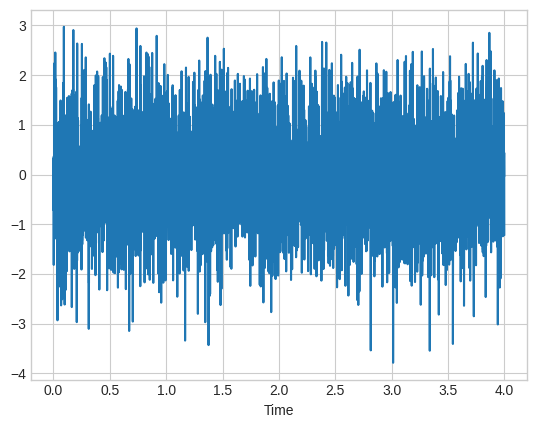

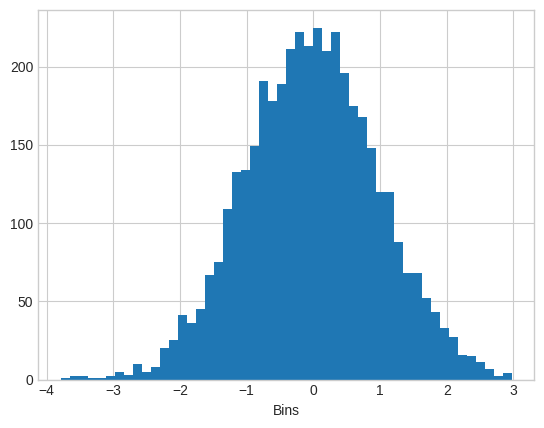

In [ ]:

# generate a sample
Nsample=4096
Fdisc=Nsample/4 # FRECUENCIA DE MUESTREO
Tdisc=1/Fdisc
t1=np.arange(0,4,Tdisc)
# shape= np.pi     
# signal= np.random.gamma(shape,size=len(t1))
signal = np.random.normal(size=len(t1),loc=0 )
plt.plot(t1,signal)
plt.xlabel("Time")
plt.show()
# plot a histogram of the sampl
plt.hist(signal, bins=50)
plt.xlabel("Bins")
plt.show()

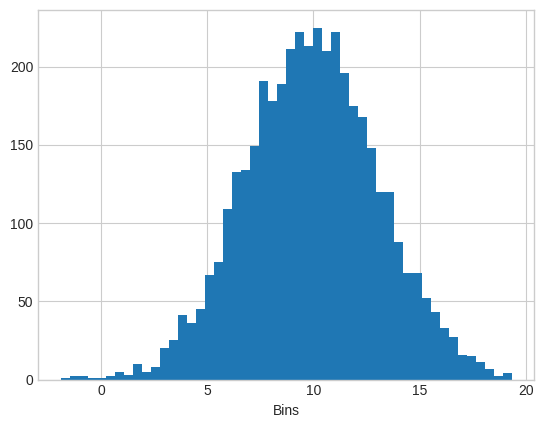

la media es: 9.92883541321141
 la varianza es 3.1201573322760883


In [ ]:
#Constante de escalamiento
alpha=np.pi
#desplazamiento
b=10
#Signal nueva
signal_2=signal*alpha+b
plt.hist(signal_2, bins=50)
plt.xlabel("Bins")
plt.show()
mean,std=stats.distributions.norm.fit(signal_2)

print(f'la media es: {mean}\n la varianza es {std}')

##Estimacion de parametros  y funcion de densidad de probabilidad


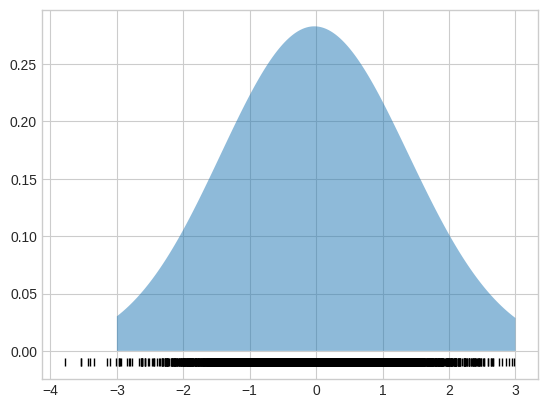

In [ ]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
x_d = np.linspace(-3, 3, Nsample)
kde.fit(signal[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(signal, np.full_like(x_d, -0.01), '|k', markeredgewidth=1)


In [ ]:
#Estimacion de parametros
import scipy.stats
mean,std=scipy.stats.distributions.norm.fit(signal)
std=std**2
print(f'la media es: {mean}\n la varianza es {std}')

la media es: -0.022652391520992854
 la varianza es 0.9864004049728369


In [ ]:

class MVE():

  """
  
        class that is in charge of handling the estimation by maximum likelihood, 
        for which 3 parameters are entered:
         --------------------------------------
         --------------------------------------
         Parameters
         --------------------------------------------
         X_function_Estimate {ndarray} -- Array that have the function 
         that needs to be estimated under some probability model.

         plot{Boolean}-- Parameter that indicate if the user want to plot the 
         log likely hood function. [default:True]

         hist{Boolean}-- Parameter that indicate if the user want to plot the 
         histogram with the estimate function. [default:True]


  """
  def __init__(self,X_function_estimate: np.array,plot=True,hist=True):
    self.X_function_estimate=X_function_estimate
    self.plot=plot
    self.hist=hist
    self.N=len(self.X_function_estimate)
  
  def Gaussian(self,median_limits: np.array, varian_limits: np.array,espace : float =0.10):
     """
      Function that make the MVE with a gaussian distribution
      ---------------------------------------------------------------
      Parameters
      ---------------------------------------------------------------
      median_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible means.

      varian_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible variances.
      espace{float}--constant  for the spacing of the vector of means and variances

      Returns
      ---------------------------------------------------------------
      media_estimate{float}-- THE ESTIMATED AVERAGE FOR THE FUNCTION 
      varian_estimate{float}-- THE ESTIMATED VARIANCE FOR THE FUNCTION
      gaussian_estimate{np.array}-- THE ESTIMATED DISTRIBUTION

      
     """  
     
     media = np.arange(median_limits[0], median_limits[1], espace)
     varian = np.arange(varian_limits[0], varian_limits[1], espace)
     media, varian = np.meshgrid(media, varian)
     log = -(self.N/2*np.log(2*np.pi)+self.N/2*np.log(varian)+(np.sum(np.square(self.X_function_estimate))-2*media*np.sum(self.X_function_estimate)\
                                                   +self.N*media**2)/(2*varian))
     posicionmax=np.where( log== np.amax(log))
     media_estimate=media[posicionmax[0],posicionmax[1]]
     varian_estimate=varian[posicionmax[0],posicionmax[1]]


     
    #  if(self.plot):
    #   fig=pl.figure(figsize=(6,6))
    #   ax=Axes3D(fig)
    #   ax.plot_surface(media,varian,log)
    #   pl.title("log likely hood of gaussian [mean(X) and varianza[Y]] ")
    #   # pl.show()

    #  gaussian_estimate= np.random.normal(media_estimate, np.sqrt(varian_estimate), N)  
    #  if(self.hist):
    #    Nbins = int(1 + 3.322*np.log2(self.N))
    #    plt.figure(figsize=(8,8))
    #    plt.hist(self.X_function_estimate,bins=Nbins,color="orange",label="Original")
    #    plt.hist(gaussian_estimate,bins=Nbins,color="blue",label="Estimation-Varian {}-median {}".format(varian_estimate,media_estimate))
    #    plt.legend()
    #    plt.title("original and estimated comparison")

    
     return media_estimate,varian_estimate

  def Exponential(self,lambda_limits:np.array,espace : float =0.10):
    """
      Function that make the MVE with a Exponential distribution
      ---------------------------------------------------------------
      Parameters
      ---------------------------------------------------------------
      lambda_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible lambdas.

      espace{float}--constant  for the spacing of the vector of lambdas

      Returns
      ---------------------------------------------------------------
      lambda_estimate{float}-- THE ESTIMATED lambda FOR THE FUNCTION 
      estimated_exponential{np.array}-- THE ESTIMATED DISTRIBUTION

    """
    
    lambdas = np.arange(lambda_limits[0], lambda_limits[1], espace)
    log_estimation=self.N*np.log(lambdas)-lambdas*np.sum(self.X_function_estimate)
    posicionmax=np.where(log_estimation== np.amax(log_estimation))
    lambda_estimate=lambdas[posicionmax]
  
    # estimated_exponential=np.random.exponential(1/lambda_estimate,size=self.N)
    if(self.plot):
      plt.figure(figsize=(6,6))
      plt.plot(lambdas, log_estimation)
      plt.xlabel('$\lambda$')
      plt.ylabel('log likely hood')
      plt.plot(lambda_estimate,log_estimation[posicionmax],color="green",label="Lambda Estimated: {}".format(lambda_estimate),marker='o')
      plt.legend()
      plt.show()
      estimated_exponential=np.random.exponential(lambda_estimate,size=self.N)
    if(self.hist):
      Nbins = int(1 + 3.322*np.log2(self.N))
      plt.figure(figsize=(8,8))
      plt.hist(self.X_function_estimate,bins=Nbins,color="orange",label="Original")
      plt.hist(estimated_exponential,bins=Nbins,color="blue",label="Estimation-lambda{}".format(lambda_estimate))
      plt.legend()
      plt.title("original and estimated comparison")
    
    return lambda_estimate,estimated_exponential

  def Gauss_estimate_fit(self):
      """
       
      function used by the scipy library to acquire the mean and variance parameters 
      for a Gaussian distribution appropriate to the shape of the training vector

      Parameters
      ---------------------------------------------
      None

      Return
      ---------------------------------------------
      mean{float}--The mean estimate
      var{float}-- the var estimate 

      """

      mean,var=scipy.stats.distributions.norm.fit(self.X_function_estimate)
      
      return mean,var

  def Poisson(self,lambdas_limits:np.array,espace : float =0.10):
    """
      Function that make the MVE with a Poisson distribution
      ---------------------------------------------------------------
      Parameters
      ---------------------------------------------------------------
      lambda_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible lambdas.

      espace{float}--constant  for the spacing of the vector of lambdas

      Returns
      ---------------------------------------------------------------
      lambda_estimate{float}-- THE ESTIMATED lambda FOR THE FUNCTION 
      estimated_poisson{np.array}-- THE ESTIMATED DISTRIBUTION

    """
    lam = np.arange(lambdas_limits[0], lambdas_limits[1], espace)
    log_est=-self.N*lam+np.log(lam)*np.sum(self.X_function_estimate)-np.sum(np.log(factorial(self.X_function_estimate)))
    p_max=np.where( log_est == np.amax(log_est))
    lambda_est=lam[p_max]
    estimated_poisson=np.random.poisson(lambda_est,self.N)
    if(self.plot):
      plt.figure(figsize=(6,6))
      plt.plot(lam, log_est)
      plt.xlabel('$\lambda$')
      plt.ylabel('log likely hood')
      plt.plot(lambda_est,log_est[p_max],color="green",label="Lambda Estimated: {}".format(lambda_est),marker='o')
      plt.legend()
      plt.show()
    if(self.hist):
      Nbins = int(1 + 3.322*np.log2(self.N))
      plt.figure(figsize=(8,8))
      plt.hist(self.X_function_estimate,bins=Nbins,color="orange",label="Original")
      plt.hist(estimated_poisson,bins=Nbins,color="blue",label="Estimation-lambda{}".format(lambda_est))
      plt.legend()
      plt.title("original and estimated comparison")
    
    return lambda_est,estimated_poisson
  def Uniform(self,vectorA, vectorb, n):
     ## GENERAMOS VECTOR DE A Y B
     A = np.linspace(vectorA[0], vectorA[1], n)
     B = np.linspace(vectorb[0], vectorb[1], n)
     A, B = np.meshgrid(A, B) ## GENERO LAS COMBINACIONES POSIBLES PARA A Y B
     log = -self.N*np.log(B-A)
     posicionmax=np.where( log== np.amax(log))
     A_estimate=A[posicionmax[0],posicionmax[1]]
     B_estimate=B[posicionmax[0],posicionmax[1]]
     ## GENERAMOS LA UNIFORME ESTIMADA
     UniformEstimate= np.random.uniform(A_estimate,B_estimate,self.N); 
     if(self.plot):
      fig=pl.figure(figsize=(6,6))
      ax=Axes3D(fig)
      ax.plot_surface(A,B,log)
      pl.title("log likely hood of uniform [A and B] ")
      pl.show()
     if(self.hist):
       Nbins = int(1 + 3.322*np.log2(self.N))
       plt.figure(figsize=(8,8))
       plt.hist(self.X_function_estimate,bins=Nbins,color="orange",label="Original")
       plt.hist(UniformEstimate,bins=Nbins,color="blue",label="Estimation-A {}-B {}".format(A_estimate,B_estimate))
       plt.legend()
       plt.title("original and estimated comparison")
       plt.show()
     return A_estimate,B_estimate,UniformEstimate

In [ ]:
if __name__=="__main__":

  """
  GAUSS
  """
  N =4096 # Elegimos el numero de muestras

  #   parameter vector \theta=\mu, \sigma^2
  μ  = b
  V2 = alpha
  x = np.random.normal(μ, np.sqrt(V2), N) ## FDP GAUSSIANA REAL 
  print(x.shape)
  MVE1=MVE(x) ## TENGO MIS DATOS GUARDADOS 
  Values_mean = np.array([b-2*V2, μ+2*V2]) ##VECTOR DE MEDIAS 
  Values_var = np.array([V2/2, 1.5*V2]) # VECTOR DE VARIANZAS
  espace=0.01
  media_estimate,varian_estimat=MVE1.Gaussian(Values_mean,Values_var,espace)
  print(f'Estimacion media por medio de MVE{media_estimate}\n Estimacion de varianza por medio de MVE{varian_estimat}')

(4096,)
Estimacion media por medio de MVE[10.03681469]
 Estimacion de varianza por medio de MVE[3.19079633]


#Calculo de la funcion de transferencia y respuesta impulso

#Filtro Pasa Bandas

In [ ]:
#importamos las librerias para crear el circuito 
!pip install lcapy
!apt install texlive-latex-base
!apt-get install texlive-latex-extra
!apt-get update && apt-get install -y --no-install-recommends \
    texlive-fonts-recommended \
    texlive-latex-extra \
    texlive-fonts-extra \
    dvipng \
    lmodern

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-base is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2019.202000218-1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.l

In [ ]:
from lcapy import Circuit, j, omega, s
ctt=Circuit("""
Vi 1 0_1 step;down
L1 1 2; right, size=1.5
C1 2 3; right,
R1 3 0_3; down , v=(V_o)
W 0_1 0;right
W 0 0_3;right

"""
)


/usr/local/lib/python3.10/dist-packages/lcapy/schematic.py:593: UserWarning: Have circuitikz version 1.0; should upgrade to 1.4.5 or later
  warn('Have circuitikz version %s; should upgrade to %s or later'


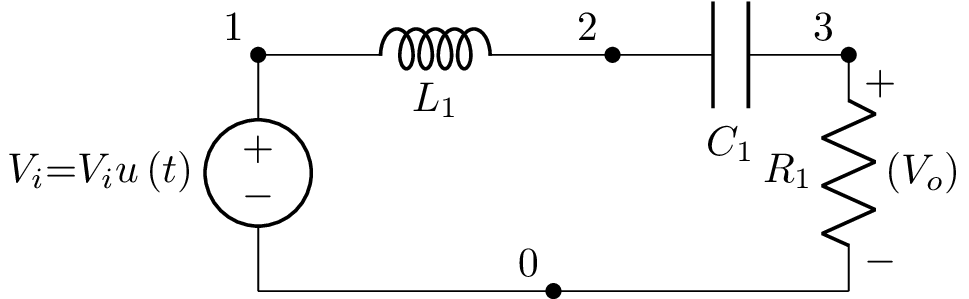

In [ ]:
ctt.draw() # Resolver

In [ ]:
H=(ctt.R1.V(s)/ctt.Vi.V(s)).simplify()
H

       C₁⋅R₁⋅s        
──────────────────────
       2              
C₁⋅L₁⋅s  + C₁⋅R₁⋅s + 1

In [ ]:
#Dando valores al circuito:
C1=1*10**(-6)
L1=5*10**(-3)
R1=1000
# R2=2000
Coeficientes_num=[C1*R1,0] #Coeficientes numerador
Coeficientes_dem=[C1*L1,C1*R1,1] #Coeficientes denominador=4.7e-4

In [ ]:
G=control.tf(Coeficientes_num,Coeficientes_dem)
print(G)


        0.001 s
-----------------------
5e-09 s^2 + 0.001 s + 1



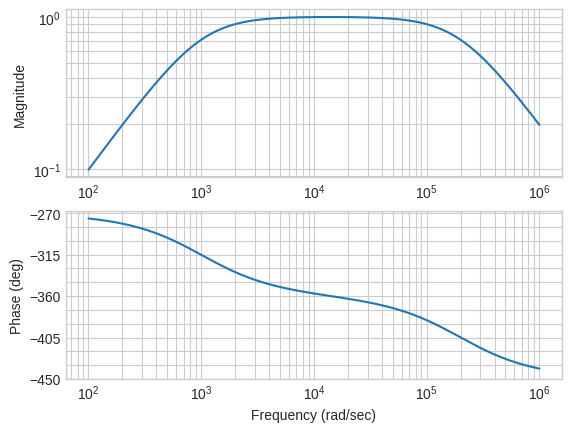

In [ ]:
mag,phase,omega = control.bode(G)

In [ ]:
H_valores=H.subs("C1",C1).subs("R1",R1).subs('L1',L1)

/usr/local/lib/python3.10/dist-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


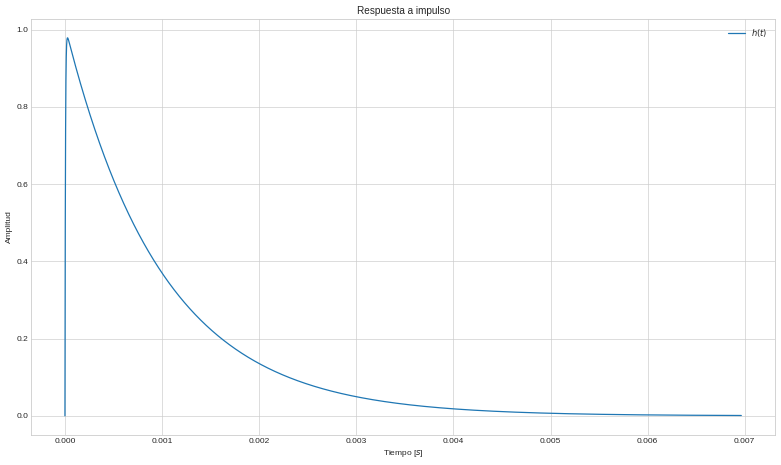

In [ ]:
Coeficientes_num=[0,C1*R1]
lti_system = lti(Coeficientes_num,Coeficientes_dem) 
t, h = lti_system.impulse(N=Nsample) # sistema LTI exitado con la función impulso
## NOS DEVUELVE 

plt.figure(figsize=(16, 9), dpi=60)
plt.plot(t, h, label='$h(t)$')

plt.grid(True)
plt.legend()
plt.title("Respuesta a impulso")
plt.xlabel("Tiempo [$s$]")
plt.ylabel("Amplitud")
plt.show()

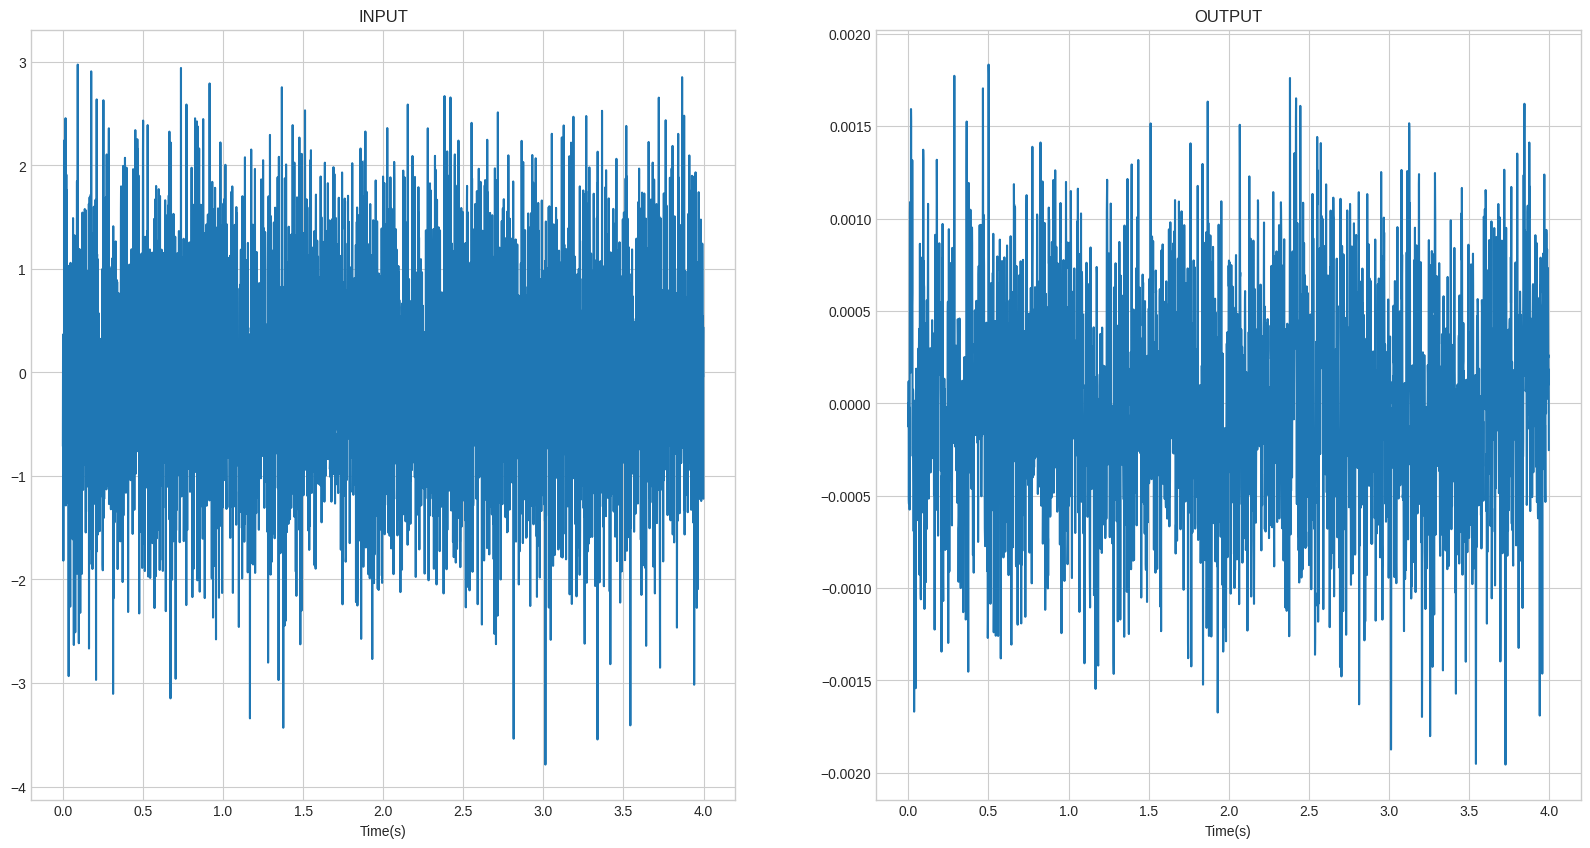

In [ ]:

_,Output_Circuit,_=lti_system.output(signal,t1) ##SALIDA DEL CIRCUITO.
Autocorrelacion_Output=np.correlate(Output_Circuit,Output_Circuit,mode="same") ## GENERAMOS LA AUTOCORRELACION
fig, axs = plt.subplots(1, 2,figsize=(20,10))
t12=np.linspace(0,20,4096)
axs[0].plot(t1,signal)
axs[0].set_title("INPUT")
axs[0].set_xlabel("Time(s)")
axs[1].plot( t1,Output_Circuit)
axs[1].set_title("OUTPUT")
axs[1].set_xlabel("Time(s)")
plt.show()



##Pasa bajos

In [ ]:
ctt2=Circuit("""
Vi 1 0_1 step;down
R1 1 2; right, size=1.5
C1 2 3; down,v=(V_o)

W 0_1 0;right
W 0 3;right
"""
)

/usr/local/lib/python3.10/dist-packages/lcapy/schematic.py:593: UserWarning: Have circuitikz version 1.0; should upgrade to 1.4.5 or later
  warn('Have circuitikz version %s; should upgrade to %s or later'


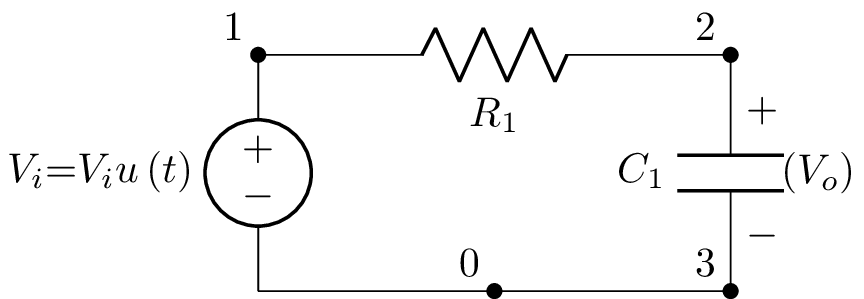

In [ ]:
ctt2.draw()

In [ ]:
H2=(ctt2.C1.V(s)/ctt2.Vi.V(s)).simplify()
H2

     1     
───────────
C₁⋅R₁⋅s + 1

In [ ]:
#Dando valores al circuito:
C1=1*10**(-6)
R1=1000
# R2=2000
Coeficientes_num=[1] #Coeficientes numerador
Coeficientes_dem=[C1*R1,1] #Coeficientes denominador=4.7e-4

In [ ]:
Low_f=control.tf(Coeficientes_num,Coeficientes_dem)
Low_f

TransferFunction(array([1]), array([0.001, 1.   ]))

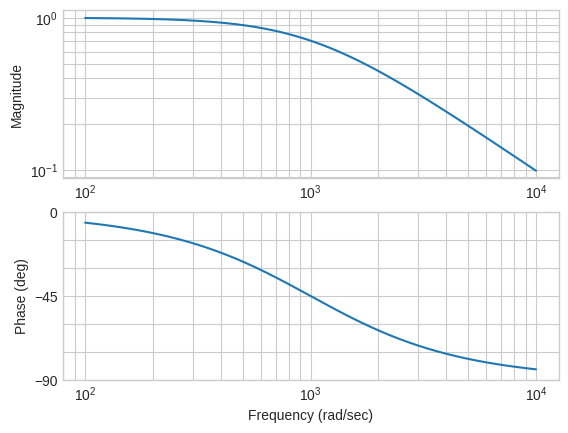

In [ ]:
mag,phase,omega = control.bode(Low_f)

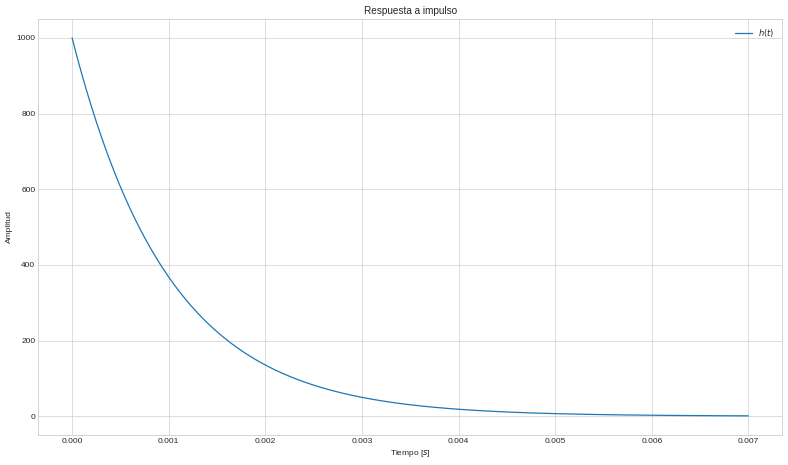

In [ ]:
H_valores=H2.subs("C1",C1).subs("R1",R1).subs('L1',L1)
lti_system2 = lti(Coeficientes_num,Coeficientes_dem) 
t, h = lti_system2.impulse(N=Nsample) # sistema LTI exitado con la función impulso
## NOS DEVUELVE 

plt.figure(figsize=(16, 9), dpi=60)
plt.plot(t, h, label='$h(t)$')

plt.grid(True)
plt.legend()
plt.title("Respuesta a impulso")
plt.xlabel("Tiempo [$s$]")
plt.ylabel("Amplitud")
plt.show()

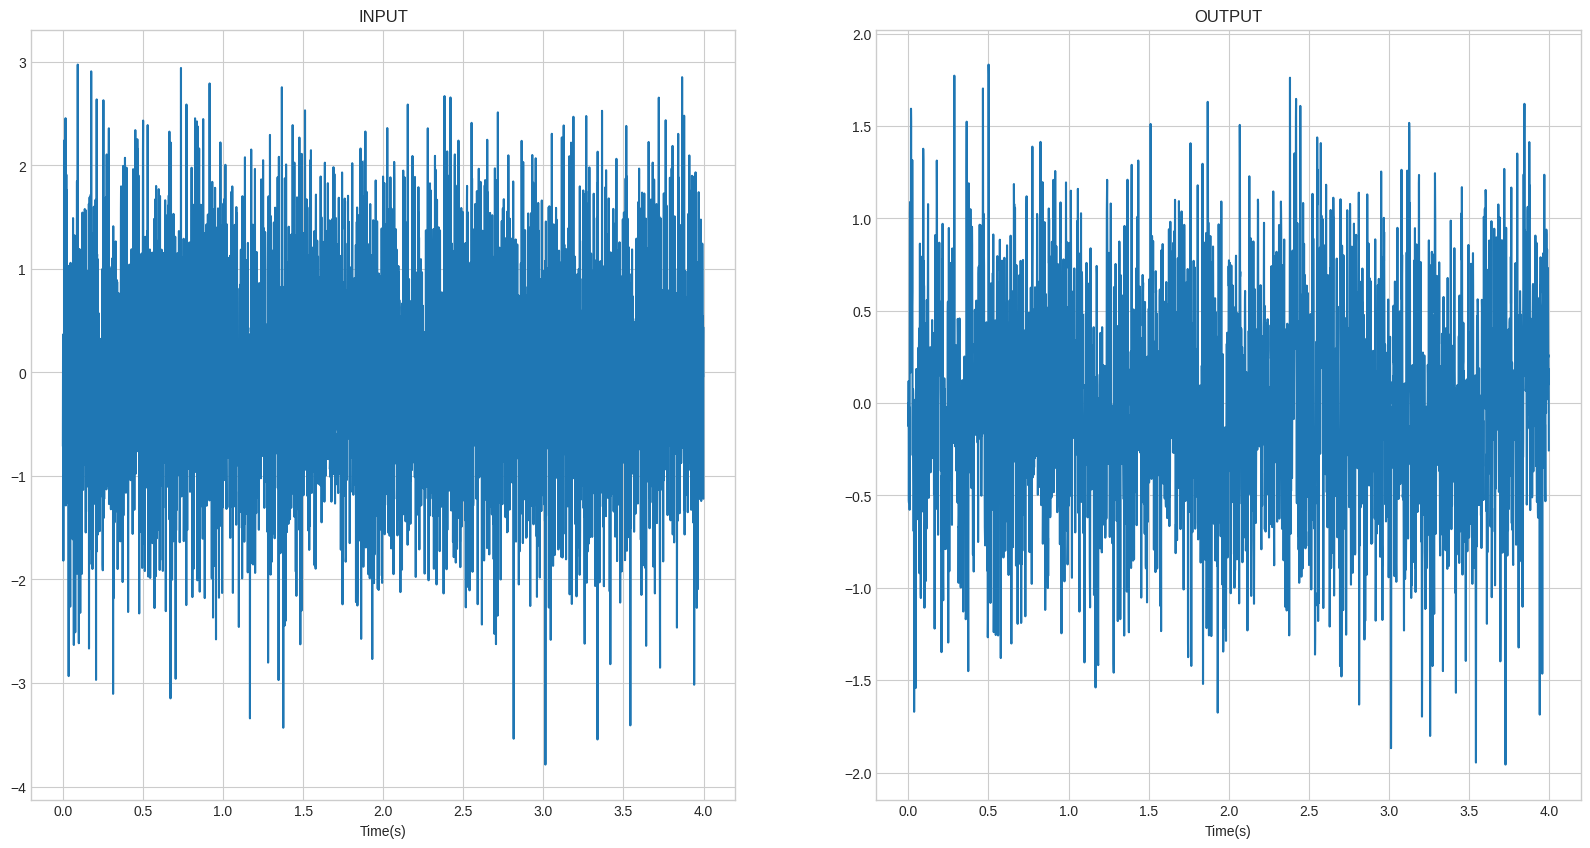

In [ ]:
_,Output_Circuit_2,_=lti_system2.output(signal,t1) ##SALIDA DEL CIRCUITO.
Autocorrelacion_Output=np.correlate(Output_Circuit_2,Output_Circuit_2,mode="same") ## GENERAMOS LA AUTOCORRELACION
fig, axs = plt.subplots(1, 2,figsize=(20,10))
t12=np.linspace(0,20,4096)
axs[0].plot(t1,signal)
axs[0].set_title("INPUT")
axs[0].set_xlabel("Time(s)")
axs[1].plot( t1,Output_Circuit_2)
axs[1].set_title("OUTPUT")
axs[1].set_xlabel("Time(s)")
plt.show()

#Estimacion de parameteros y pdf a la salida

#Pasa Bandas

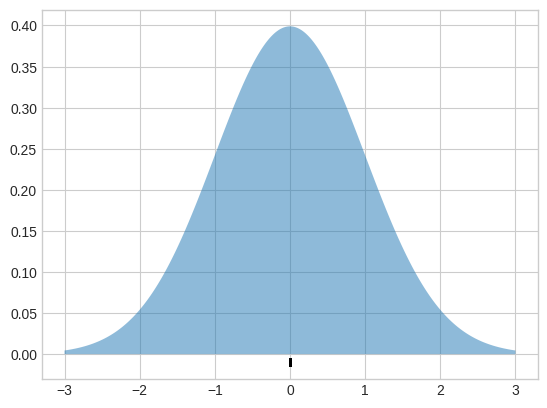

In [ ]:
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
x_d = np.linspace(-3, 3, Nsample)
kde.fit(Output_Circuit[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(Output_Circuit, np.full_like(x_d, -0.01), '|k', markeredgewidth=1)

In [ ]:

mean,std=stats.distributions.norm.fit(Output_Circuit)

print(f'la media es: {mean}\n la varianza es {std}')

la media es: -2.2388165379448498e-05
 la varianza es 0.0005521836134320873


#Pasa Bajas

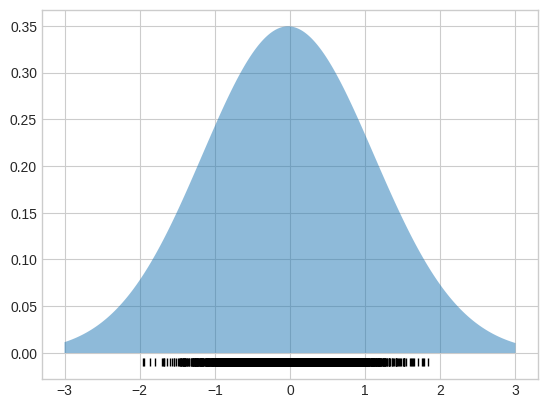

In [ ]:
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
x_d = np.linspace(-3, 3, Nsample)
kde.fit(Output_Circuit_2[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(Output_Circuit_2, np.full_like(x_d, -0.01), '|k', markeredgewidth=1)

In [ ]:
mean,std=stats.distributions.norm.fit(Output_Circuit_2)
print(f'la media es: {mean}\n la varianza es {std}')

la media es: -0.022388515130928724
 la varianza es 0.5517353792771085
